# Title

## Introduction

## Data preprocessing

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px

In [2]:
real_expenditure_GDP = pd.read_csv("data/Expenditure_based_GDP_detail.csv", skiprows=11)
real_expenditure_GDP = real_expenditure_GDP.head(31)

real_expenditure_GDP.head()

,Estimates,Q1 1961,Q2 1961,Q3 1961,Q4 1961,Q1 1962,Q2 1962,Q3 1962,Q4 1962,Q1 1963,...,Q2 2022,Q3 2022,Q4 2022,Q1 2023,Q2 2023,Q3 2023,Q4 2023,Q1 2024,Q2 2024,Q3 2024
0,Final consumption expenditure,"293,535","298,239","306,533","307,087","313,327","317,314","315,469","321,086","324,140",...,"1,865,180","1,872,169","1,877,726","1,891,011","1,895,415","1,905,538","1,907,336","1,922,829","1,931,073","1,948,849"
1,Household final consumption expenditure,"193,805","197,421","202,241","203,009","207,687","208,873","207,986","211,777","213,212",...,"1,323,013","1,323,525","1,324,084","1,336,434","1,339,046","1,341,928","1,346,226","1,356,639","1,359,823","1,371,495"
2,Goods,"85,028","87,370","89,798","89,474","93,335","93,741","93,038","95,494","96,123",...,"582,022","575,343","574,328","581,359","582,850","580,854","585,192","585,983","585,072","591,179"
3,Durable goods,"7,744","8,190","8,933","8,723","9,497","9,479","9,200","9,843","9,882",...,"168,924","165,925","166,084","171,012","170,332","173,431","178,530","178,030","174,014","178,930"
4,Semi-durable goods,"10,318","10,230","10,398","10,728","10,985","11,288","11,158","11,288","11,213",...,"103,856","101,578","101,633","104,592","104,664","100,787","100,725","103,013","103,514","103,935"


*Statistics Canada. Table 36-10-0104-01  Gross domestic product, expenditure-based, Canada, quarterly (x 1,000,000)
DOI: https://doi.org/10.25318/3610010401-eng*

In [51]:
Real_GDP = real_expenditure_GDP.melt(
    id_vars=["Estimates"], 
    var_name="Time",       
    value_name="Value"    )

In [28]:
# group the estimates
group_map = {
    # consumption
    "Final consumption expenditure": "Consumption",
    "Household final consumption expenditure": "Consumption",
    "Goods": "Consumption",
    "Durable goods": "Consumption",
    "Semi-durable goods": "Consumption",
    "Non-durable goods": "Consumption",
    "Services": "Consumption",
    "Non-profit institutions serving households' final consumption expenditure": "Consumption",
    "General governments final consumption expenditure": "Consumption",
    
    # investment
    "Gross fixed capital formation": "Investment",
    "Business gross fixed capital formation": "Investment",
    "Residential structures": "Investment",
    "Non-residential structures, machinery and equipment": "Investment",
    "Non-residential structures": "Investment",
    "Machinery and equipment": "Investment",
    "Intellectual property products": "Investment",
    "Non-profit institutions serving households' gross fixed capital formation": "Investment",
    "General governments gross fixed capital formation": "Investment",
    "Investment in inventories": "Investment",
    "Of which: business investment in inventories": "Investment",
    "Non-farm": "Investment",
    "Farm": "Investment",

    # NE
    "Exports of goods and services": "Net Exports",
    "Exports of goods": "Net Exports",
    "Exports of services": "Net Exports",
    "Less: imports of goods and services": "Net Exports",
    "Imports of goods": "Net Exports",
    "Imports of services": "Net Exports",
    
    # Others
    "Statistical discrepancy": "Others",
    "Gross domestic product at market prices": "Others",
    "Final domestic demand": "Others"
}

Real_GDP['Group'] = Real_GDP['Estimates'].map(group_map)
Real_GDP['Value'] = Real_GDP['Value'].astype(str).str.replace(',', '').astype(float)
Real_GDP.head()

,Estimates,Time,Value,Group
0,Final consumption expenditure,Q1 1961,293535.0,Consumption
1,Household final consumption expenditure,Q1 1961,193805.0,Consumption
2,Goods,Q1 1961,85028.0,Consumption
3,Durable goods,Q1 1961,7744.0,Consumption
4,Semi-durable goods,Q1 1961,10318.0,Consumption


In [3]:
# create the total consumption table
mask = real_expenditure_GDP['Estimates'].isin([
    "Household final consumption expenditure", 
    "Non-profit institutions serving households' final consumption expenditure"
])
subset = real_expenditure_GDP[mask].copy()

time_cols = [col for col in subset.columns if col.startswith("Q")]
for col in time_cols:
    subset[col] = subset[col].astype(str).str.replace(',', '').astype(float)

clean_consumption = subset.melt(
    id_vars=["Estimates"],
    value_vars=time_cols,
    var_name="time",
    value_name="consumption"
)

def convert_quarter_to_date(q_str):
    parts = q_str.split()
    quarter = parts[0] 
    year = parts[1]  
    quarter_to_month = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}
    month = quarter_to_month.get(quarter, 1)
    return datetime.strptime(f"{year}-{month:02d}-01", "%Y-%m-%d")

clean_consumption['time'] = clean_consumption['time'].apply(convert_quarter_to_date)
clean_consumption = clean_consumption.drop(columns=['Estimates']).groupby("time").sum()
clean_consumption.head()

,consumption
time,
1961-01-01,196797.0
1961-04-01,200550.0
1961-07-01,205473.0
1961-10-01,206271.0
1962-01-01,211052.0


In [7]:
# Total investment table
investment_mask = real_expenditure_GDP['Estimates'].isin([
    "Business gross fixed capital formation",
    "Non-profit institutions serving households' gross fixed capital formation"
])
subset_investment = real_expenditure_GDP[investment_mask].copy()

time_cols = [col for col in subset_investment.columns if col.startswith("Q")]
for col in time_cols:
    subset_investment[col] = subset_investment[col].astype(str).str.replace(',', '').astype(float)

clean_investment = subset_investment.melt(
    id_vars=["Estimates"],
    value_vars=time_cols,
    var_name="time",
    value_name="investment"
)

clean_investment['time'] = clean_investment['time'].apply(convert_quarter_to_date)
clean_investment = clean_investment.drop(columns=['Estimates']).groupby("time").sum()
clean_investment.head()

,investment
time,
1961-01-01,50342.0
1961-04-01,50486.0
1961-07-01,52168.0
1961-10-01,51834.0
1962-01-01,51595.0


In [8]:
# Total government spending table
gov_mask = real_expenditure_GDP['Estimates'].isin([
    "General governments final consumption expenditure",
    "General governments gross fixed capital formation"
])
subset_gov = real_expenditure_GDP[gov_mask].copy()

time_cols = [col for col in subset_gov.columns if col.startswith("Q")]
for col in time_cols:
    subset_gov[col] = subset_gov[col].astype(str).str.replace(',', '').astype(float)

clean_gov = subset_gov.melt(
    id_vars=["Estimates"],
    value_vars=time_cols,
    var_name="time",
    value_name="gov_spending"
)

clean_gov['time'] = clean_gov['time'].apply(convert_quarter_to_date)
clean_gov= clean_gov.drop(columns=['Estimates']).groupby("time").sum()
clean_gov.head()

,gov_spending
time,
1961-01-01,112816.0
1961-04-01,114737.0
1961-07-01,119348.0
1961-10-01,119115.0
1962-01-01,121328.0


## Visualization

In [36]:
component_GDP = clean_consumption.merge(clean_investment, on="time").merge(clean_gov, on = "time")

component_GDP = component_GDP.reset_index() 
component_GDP["time"] = pd.to_datetime(component_GDP["time"])
GDP_long = component_GDP.melt(id_vars=["time"], var_name="Category", value_name="Value")
GDP_long.head()

,time,Category,Value
0,1961-01-01,consumption,196797.0
1,1961-04-01,consumption,200550.0
2,1961-07-01,consumption,205473.0
3,1961-10-01,consumption,206271.0
4,1962-01-01,consumption,211052.0


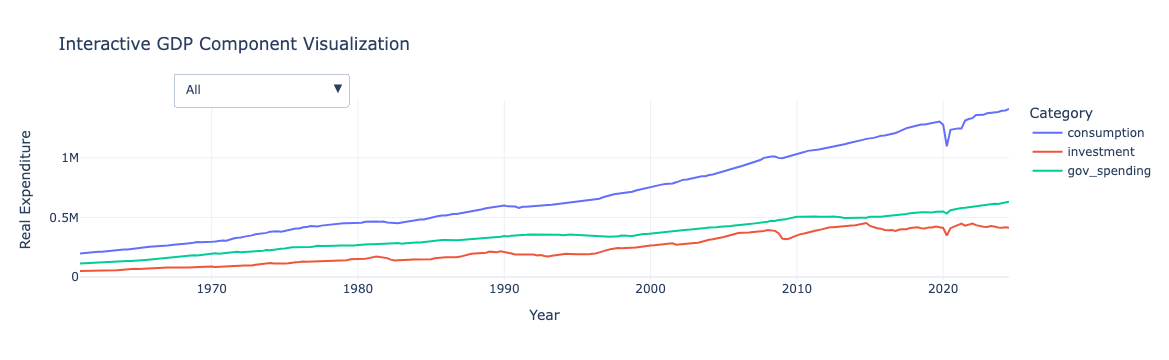

In [37]:
fig = px.line(GDP_long, 
              x="time", 
              y="Value", 
              color="Category", 
              title="Interactive GDP Component Visualization",
              labels={"Value": "Real Expenditure", "time": "Year"},
              template="plotly_white")


fig.update_layout(
    updatemenus=[{
        "buttons": [
            {
                "label": "All",
                "method": "update",
                "args": [
                    {"visible": [True, True, True]},
                    {"title": "All GDP Components"}
                ]
            },
            {
                "label": "Consumption",
                "method": "update",
                "args": [
                    {"visible": [True, False, False]},
                    {"title": "Household Consumption"}
                ]
            },
            {
                "label": "Investment",
                "method": "update",
                "args": [
                    {"visible": [False, True, False]},
                    {"title": "Business Investment"}
                ]
            },
            {
                "label": "Government Spending",
                "method": "update",
                "args": [
                    {"visible": [False, False, True]},
                    {"title": "Government Spending"}
                ]
            }
        ],
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }]
)


fig.show()

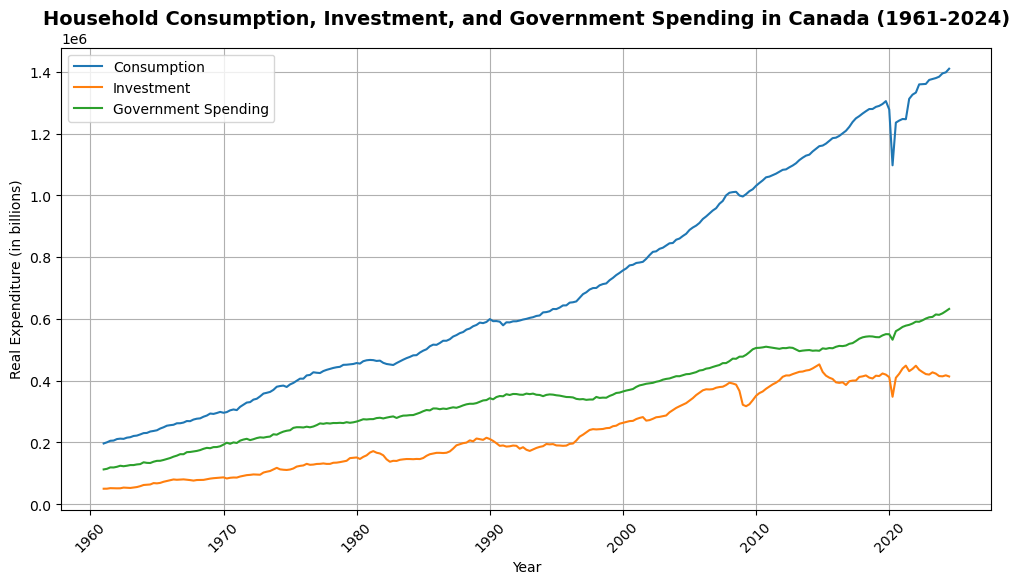

In [9]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=clean_consumption, x='time', y='consumption', label='Consumption')
sns.lineplot(data=clean_investment, x='time', y='investment', label='Investment')
sns.lineplot(data=clean_gov, x='time', y='gov_spending', label='Government Spending')

plt.title("Household Consumption, Investment, and Government Spending in Canada (1961-2024)", fontsize=14, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Real Expenditure (in billions)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

## Prediction

## Discussion 